In [3]:
"""
This computes local sieve scores for heads.
"""

import pickle as pkl
import numpy as np
import tokenization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import os

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [12]:
def init(task_name):
    """
    Set this to the path of the input sentences.
    """
    input_file='./texts/glue_data_{}_test_small.tsv'.format(task_name.upper())
    """
    Set this to the path of your attention weights file. Attention weights should be a 
    list of num_sents tensors each of size (12 ,12 ,128 ,128) [num_layer, num_heads, max_seq_len, max_seq_len].
    """
    attn_file1 = './pkl_dir/attention_weights_{}_small.pkl'.format(task_name)
    task_name=task_name
    
    # Read attention weights file.
    a = pkl.load(open(attn_file1, 'rb'))
    print("len of a {}".format(len(a)))
    print("shape of a {}".format(a[0].shape))
    
    # Read text file.
    f = open(input_file, 'r')
    f1 = f.readlines()
    f1 = f1[1:]   #Ignore the 1st row which has label.
    print("Total sentences in test set: {}".format(len(f1)))
    return f1, a

In [13]:
# Calc locality bias score for band2.
def calc_score_band2(a, f1, tokenizer, task_name):
    out_band2 = np.zeros((num_sents, 12, 12))
    print(num_sents)
    for i in range(num_sents):

        sent = f1[i].split('\t')
        if task_name in ['qqp', 'qnli']:
            sent_a = tokenizer.tokenize(sent[1])
            sent_b = tokenizer.tokenize(sent[2])
            final_sent = ['CLS '] + sent_a + [' SEP '] + sent_b + [' SEP']
        elif task_name == 'mrpc':
            sent_a = tokenizer.tokenize(sent[3])
            sent_b = tokenizer.tokenize(sent[4])
            final_sent = ['CLS '] + sent_a + [' SEP '] + sent_b + [' SEP']
        elif task_name == 'sst-2':
            final_sent = ['CLS '] + tokenizer.tokenize(sent[1])+ [' SEP']
        sent_len = len(final_sent)
        #print(f1[i])
        #print(final_sent)
        #print(sent_len)
        if sent_len > max_seq_len:
            sent_len = max_seq_len

        for l in range(num_layers):
            for h in range(num_heads):
                attn_per_head = a[i][l,h][:sent_len, :sent_len]
                sent_score = 0
                for token in range(sent_len):
                    avg_attn_over_all_toks = np.sum(attn_per_head[token, :])/sent_len
                    band_size = (min(token+2, sent_len)+1) - max(0, token-2) 
                    token_score = np.sum(attn_per_head[token, max(0, token-2):(min(token+2, sent_len)+1)])/band_size
                    token_score = token_score/avg_attn_over_all_toks
                    sent_score+=token_score
                sent_score = sent_score/sent_len
                out_band2[i,l,h] = sent_score
    return out_band2

In [14]:
# Visualize locality bias score for band2.
def visualize_band2():
    for i in range(12): 
        plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
        axes = plt.gca()
        axes.set_ylim([0,1.1])
        plt.ylabel('Layer ' + str(i))
        plt.violinplot(out_band2[:, i, :])
        #plt.savefig("band2_score_layer{}.png".format(i))
        plt.show()

In [15]:
#uniform/random band score.
def get_baseline(width, tokenizer, f1, task_name):
    uniform_baseline_score = []
    print(num_sents)
    for i in range(num_sents):

        sent = f1[i].split('\t')
        if task_name in ['qqp', 'qnli']:
            sent_a = tokenizer.tokenize(sent[1])
            sent_b = tokenizer.tokenize(sent[2])
            final_sent = ['CLS '] + sent_a + [' SEP '] + sent_b + [' SEP']
        elif task_name == 'mrpc':
            sent_a = tokenizer.tokenize(sent[3])
            sent_b = tokenizer.tokenize(sent[4])
            final_sent = ['CLS '] + sent_a + [' SEP '] + sent_b + [' SEP']
        elif task_name == 'sst-2':
            final_sent = ['CLS '] + tokenizer.tokenize(sent[1])+ [' SEP']
        sent_len = len(final_sent)
        #print(f1[i])
        #print(final_sent)
        #print(sent_len)
        if sent_len > max_seq_len:
            sent_len = max_seq_len
        #score = (2*width+1)/sent_len
        # Change the threshold here.
        score = 1
        uniform_baseline_score.append(score)
    print('Average baseline score for {}, band{}: {}'.format(task_name, width, np.mean(uniform_baseline_score)))
    return uniform_baseline_score

In [16]:
# p-val calculation
def ztest_own(pop1, th, n, alternate='smaller'):
    mu1, v = np.mean(pop1), np.std(pop1) 
    z = (mu1 - th)/(v/np.sqrt(n))
    df = n - 1
    rv = st.t(df)
    if alternate == 'larger':
        return rv.cdf(z)
    else:
        #print('here')
        return 1 - rv.cdf(z)
    
def get_pvalues(uniform_baseline_score, out_band):
    alt_pval = np.zeros([num_layers, num_heads])
    for l in range(num_layers):
            for h in range(num_heads):
                single_head_scores = []
                for s in range(num_sents):
                    single_head_scores.append(out_band[s][l,h])
                if len(uniform_baseline_score) != len(single_head_scores):
                    raise "Population lengths not same for p-value test."
                score = ztest_own(single_head_scores, uniform_baseline_score[0], num_sents)
                alt_pval[l,h] = score
    return alt_pval

In [19]:
# visualize pval and save the calculated local sieve scores.
def vis_and_save(width, out_band, alt_pval, task_name, output_dir):
    plt.figure(figsize=(8,6))
    g = sns.heatmap(np.average(out_band, axis=0), cmap='Blues', annot=True)   
    g.set(xticklabels=np.arange(12), yticklabels=np.arange(12))
    plt.xlabel('heads')
    plt.ylabel('layers')
    plt.title('Avg loc bias for {}, band{}'.format(task_name, width))
    #plt.savefig(os.path.join(output_dir, 'avg_locbias_band{}_{}_1x.png'.format(width, task_name)))
    plt.figure(figsize=(8,6))
    g = sns.heatmap(np.array(np.round(alt_pval,2)), annot=True, center=0.05)
    g.set(xticklabels=np.arange(12), yticklabels=np.arange(12))
    plt.xlabel('heads')
    plt.ylabel('layers')
    plt.title('p-value for {}, band{}'.format(task_name, width))
    #plt.savefig(os.path.join(output_dir, "p-values_locbias_band{}_{}.png".format(width, task_name)))
    head_frac_loc = len([x for x in np.reshape(alt_pval, [num_layers*num_heads,]) if x < 0.05])/(num_heads*num_layers)
    rej_heads = [i for i,x in enumerate(np.reshape(alt_pval, [num_layers*num_heads,])) if x < 0.05]
    print("Fraction of heads rejecting the locality hypothesis for {}, band{}: {}".format(task_name, width, head_frac_loc))
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    pkl.dump(out_band, open(output_dir + "all_heads_all_sents_locbias_band{}_{}.pkl".format(width, task_name), 'wb'))

len of a 20
shape of a (12, 12, 128, 128)
Total sentences in test set: 20
20
20
Average baseline score for qnli, band2: 1.0
Fraction of heads rejecting the locality hypothesis for qnli, band2: 0.9097222222222222
len of a 20
shape of a (12, 12, 128, 128)
Total sentences in test set: 20
20
20
Average baseline score for qqp, band2: 1.0
Fraction of heads rejecting the locality hypothesis for qqp, band2: 0.7638888888888888
len of a 20
shape of a (12, 12, 128, 128)
Total sentences in test set: 20
20
20
Average baseline score for mrpc, band2: 1.0
Fraction of heads rejecting the locality hypothesis for mrpc, band2: 0.8958333333333334
len of a 20
shape of a (12, 12, 128, 128)
Total sentences in test set: 20
20
20
Average baseline score for sst-2, band2: 1.0
Fraction of heads rejecting the locality hypothesis for sst-2, band2: 0.8194444444444444


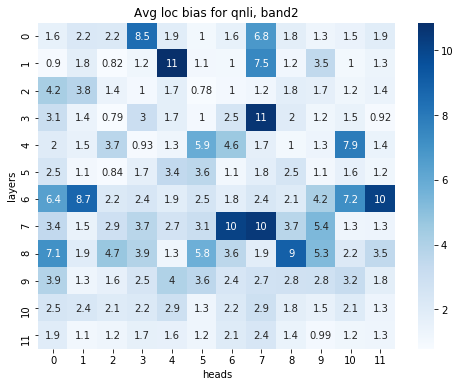

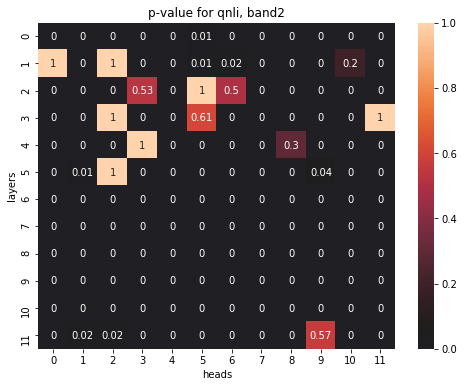

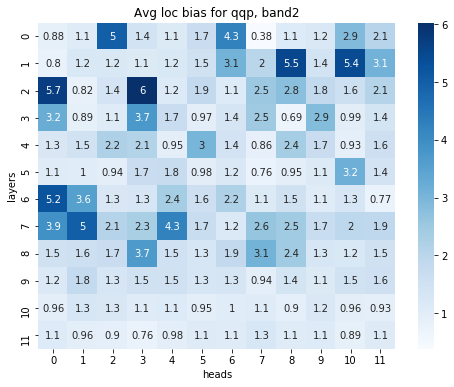

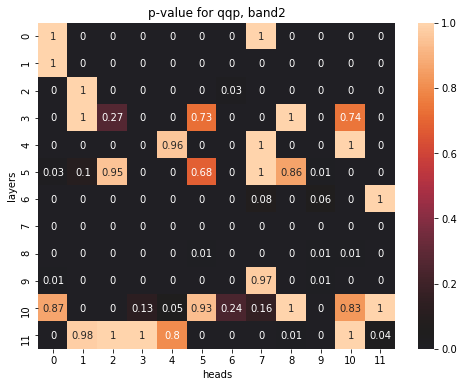

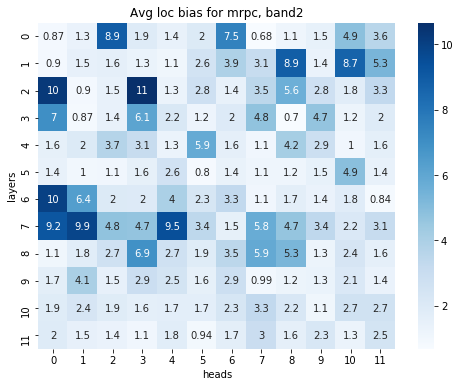

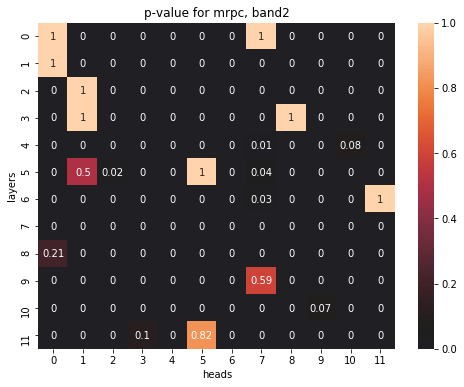

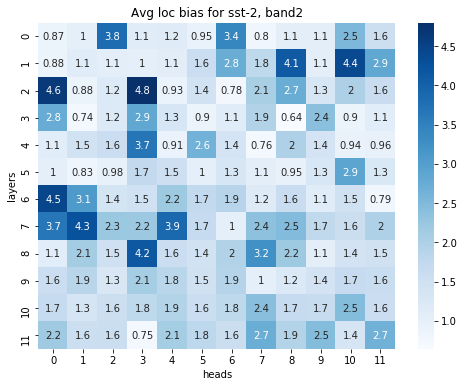

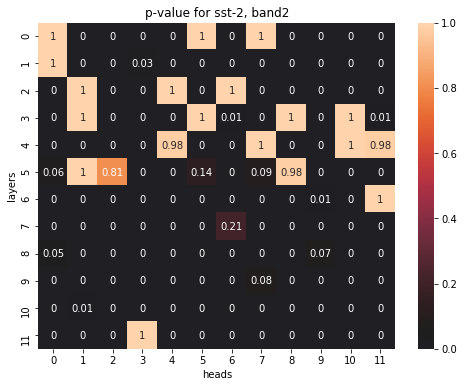

In [20]:
# Driver cell
for task_name in  ['qnli', 'qqp', 'mrpc', 'sst-2']:
    %reset_selective -f "^a$"
    num_sents = 20   # Change this to number of sentences considered.
    num_layers, num_heads=12,12
    max_seq_len = 128
    output_dir = "./sieve_scores/local/"
    tokenizer = tokenization.FullTokenizer(vocab_file="vocab.txt", do_lower_case=True)

    f1, a = init(task_name)
    #Band2
    out_band2 = calc_score_band2(a, f1, tokenizer, task_name)
    # This visualization of p-values is for baseline score = 1, 
    # this can be changed to other thresholds.
    uniform_baseline_score = get_baseline(2, tokenizer, f1, task_name)
    alt_pvals = get_pvalues(uniform_baseline_score, out_band2)
    vis_and_save(2, out_band2, alt_pvals, task_name, output_dir)